In [1]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Flat Seabed
from fenics import *
from mshr import *
import numpy as np
import matplotlib.pyplot as plt
import meshio
from math import sin, cos, pi
import time

t_start = time.time()

# Simulation parameters
Lx, Ly = 30, 15                    # Domain size (30 by 15 non-dimensional units)
delta = 0.04                       # Thickness of the boundary
resolution = 160                   # Mesh resolution
T = 2.5                            # Time period for wave oscillations
g = 9.81                           # Gravitational acceleration
rho = 1025                         # Density of water
kh = 0.1                           # Shallow water condition kh << 1
omega = 2 * np.pi / T              # Angular frequency
h = g * kh ** 2 / omega ** 2       # Height of the water surface over the sea bed
c = np.sqrt(g * h)                 # Characteristic speed
k = omega / c                      # Wave number
k_star = 1e5                       # Stiffness coefficient of seabed
b_star = 1e2                       # Damping coefficient of seabed

save_file = 1                      # If 1, save the data
xdmf_phi = XDMFFile("phi_flat11.xdmf")   # The file to save the velocity potential field
timeseries_phi = TimeSeries("phi_series_flat11")
width = 0.5
width_y = 0.5
inflow_length = 4
inflow_height = 3
# Simulation domain configuration and generate mesh

channel = Rectangle(Point(0, -Ly/2), Point(Lx, Ly/2))
domain = channel
mesh = generate_mesh(domain, resolution)

cell_markers = MeshFunction("bool", mesh, mesh.topology().dim())
cell_markers.set_all(False)
for cell in cells(mesh):
    p = cell.midpoint()
    if p.x() < 0.2 and p.y() > -3 and p.y() < 3:
        cell_markers[cell] = True
mesh = refine(mesh, cell_markers, redistribute=True)

# Functionspace and functions

V = FunctionSpace(mesh, 'P', 2)
psi = TestFunction(V)      # Test function for the velocity potential
phi_p = TrialFunction(V)   # Phi at time step (n+1)
phi_n = Function(V)        # Phi at time step n
phi_m = Function(V)        # Phi at time step (n-1)
phi = Function(V)          # Function to store the solution

# Define boundaries

class InflowBoundary(SubDomain):
    def inside(self,x,on_boundary):
        return 0 < x[0] and x[0] < inflow_length and -0.5 * inflow_height < x[1] and x[1] < 0.5 * inflow_height
    
class InflowBoundary_nowave(SubDomain):
    def inside(self,x,on_boundary):
        return 0 < x[0] and x[0] < inflow_length and (-0.5 * inflow_height > x[1] or x[1] > 0.5 * inflow_height)

class SpongeLayer(SubDomain):
    def inside(self,x,on_boundary):
        return x[0] > (Lx - width) and x[0] < Lx

class TopFlankSponge(SubDomain):
    def inside(self,x,on_boundary):
        return x[1] > (0.5 * Ly - width_y) and x[1] < (0.5 * Ly)

class BottomFlankSponge(SubDomain):
    def inside(self,x,on_boundary):
        return x[1] < (-0.5 * Ly + width_y) and x[1] > (-0.5 * Ly)



boundary_markers = MeshFunction("size_t",mesh,mesh.topology().dim()-1)
boundary_markers.set_all(0)
inflow_wave = InflowBoundary()
inflow_wave.mark(boundary_markers, 1)
inflow_nowave = InflowBoundary_nowave()
inflow_nowave.mark(boundary_markers, 2)
sponge = SpongeLayer()
sponge.mark(boundary_markers,3)
top = TopFlankSponge()
top.mark(boundary_markers,4)
bottom = BottomFlankSponge()
bottom.mark(boundary_markers,5)
# outflow = 'near(x[0],30)'
# walls = 'near(x[1],-7.5)||near(x[1],7.5)'

# Boundary conditions 
# In FEniCS, the Neumann condition which represents artificial absorbing is the default, so it's not assigned explicitly.

inflow_profile = ('A * cos(k * x[0] - omega * t) * cos(pi * x[1] / inflow_height) * 0.5 * (1 + tanh(x[0] - 0.5 * inflow_length)) ')
inflow_f = Expression(inflow_profile, A=1.0, alpha=0.5, k=k, omega=omega, t=0, inflow_length=inflow_length, inflow_height=inflow_height, degree=2)
bc_inlet = DirichletBC(V, inflow_f, inflow_wave)
bc_inlet1 = DirichletBC(V, Constant(0.0), inflow_nowave)
# bc_top_bottom = DirichletBC(V, Constant(0.0), walls)
# bc_phi = [bc_inlet, bc_inlet1, bc_top_bottom]
bc_phi = [bc_inlet]

# Define effective gravity function

omega = 2 * np.pi / T  # Angular frequency
g_eff = g * (1 + rho * g / (k_star + 1j * b_star * omega))
n = FacetNormal(mesh) # Outward normal vector on the facets (boundaries) of the mesh
dt = T / 200 # Length of each time step

# Check the CFL condition

delta_x = mesh.hmin()
delta_t = dt
if c * delta_t <= delta_x:
    print("CFL condition satisfied.")
else:
    print("CFD condition not satisfied. c:", c, "delta_t:", delta_t, "delta_x:", delta_x)

# Variational form to be solved

F = (phi_p * psi / dt ** 2 - 2 * phi_n * psi / dt ** 2 + phi_m * psi / dt ** 2 ) * dx \
    + 0.5 * dot(h * grad(phi_p), grad(g * psi)) * dx \
    + 0.5 * dot(h * grad(phi_n), grad(g * psi)) * dx \
#     - 0.5 * dot(psi * g * h * grad(phi_n), n) * ds(1) \
#     - 0.5 * dot(psi * g * h * grad(phi_p), n) * ds(1) \

a = lhs(F) # Terms involving the unknown function.
L = rhs(F) # Boundary conditions, source terms, and known functions.

# If the boundary conditions are dependent on time, update the boundary conditions

def update_bc(new_t):
    inflow_f.t = new_t
    bc_inlet = DirichletBC(V, inflow_f, inflow_wave)
    bc_phi = [bc_inlet]

def relaxation_factor(x,Lx=Lx,width=width,beta=1):
    norm = np.abs(np.tanh(beta * (Lx - width - (Lx - 0.5 * width))))
    return 0.5 * (1 + np.tanh(beta * (x - (Lx - 0.5 * width)))/norm) if x > (Lx - width) else 0.0
# Simulate

def relaxation_factor_y(y,Ly=Ly,width_y=width_y,beta=2):
    if y > (0.5 * Ly - width_y):
        return 0.5 * (1 + np.tanh(beta * (y - (0.5 * Ly - 0.5 * width_y))))
    elif y < (width_y - 0.5 * Ly):
        return 0.5 * (1 -np.tanh(beta * (y + (0.5 * Ly - 0.5 * width_y))))
    else:
        return 0




CFL condition satisfied.


In [4]:
phi_R = Function(V)
timeseries_phi = TimeSeries("phi_series_flat11")
timeseries_phi.retrieve(phi_R.vector(),65)

<Figure size 640x480 with 0 Axes>

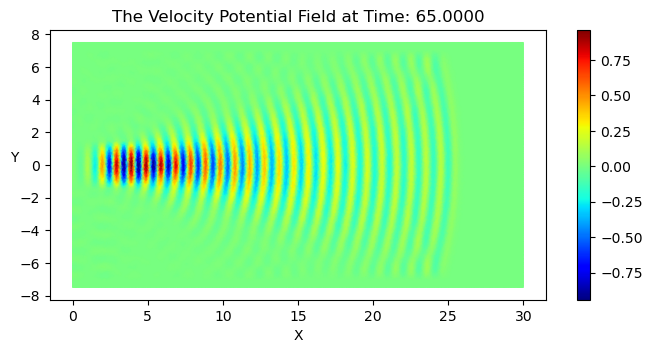

In [8]:
phi_R = Function(V)
timeseries_phi = TimeSeries("phi_series_flat11")
timeseries_phi.retrieve(phi_R.vector(),55)

plt.clf()
phi_array = phi_R.compute_vertex_values(mesh)
phi_array = phi_array.reshape((mesh.num_vertices(), ))
plt.figure(figsize = (8, 3.5))
plt.xlabel("X")
plt.ylabel("Y",rotation=0)
plt.title("The Velocity Potential Field at Time: 65.0000")
plt.tripcolor(mesh.coordinates()[:, 0], mesh.coordinates()[:, 1], mesh.cells(), phi_array, shading="gouraud", cmap="jet")
plt.colorbar()

In [12]:
probe_num = 400
time_step = 400
wave_length = 2 * np.pi / k
y_list = np.linspace(-7.5,7.5,probe_num)
x = 4
A4 = np.zeros((time_step,probe_num))
A8 = np.zeros((time_step,probe_num))
A12 = np.zeros((time_step,probe_num))
A16 = np.zeros((time_step,probe_num))
A20 = np.zeros((time_step,probe_num))
A24 = np.zeros((time_step,probe_num))
gap = T / 200
for step in range(time_step):
    timeseries_phi.retrieve(phi_R.vector(),55 + gap * (step+1))
    for j in range(probe_num):
        y = y_list[j]
        A4[step][j] = phi_R(Point(4,y)) ** 2
        A8[step][j] = phi_R(Point(4+4*wave_length,y)) ** 2
        A12[step][j] = phi_R(Point(4+8*wave_length,y)) ** 2
        A16[step][j] = phi_R(Point(4+12*wave_length,y)) ** 2
        A20[step][j] = phi_R(Point(4+16*wave_length,y)) ** 2
        A24[step][j] = phi_R(Point(4+20*wave_length,y)) ** 2
                            
    
    

In [13]:
mean4 = []
mean8 = []
mean12 = []
mean16 = []
mean20 = []
mean24 = []
for h in range(time_step):
    
    mean4.append(np.mean(A4[:,h]))
    mean8.append(np.mean(A8[:,h]))
    mean12.append(np.mean(A12[:,h]))
    mean16.append(np.mean(A16[:,h]))
    mean20.append(np.mean(A20[:,h]))
    mean24.append(np.mean(A24[:,h]))

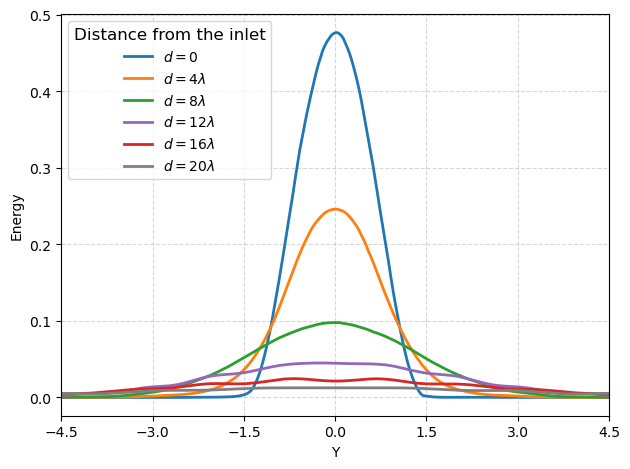

In [18]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#d62728', '#7f7f7f']

# Plot each curve with the new colors
plt.plot(y_list, mean4, color=colors[0], label="$d=0$", linewidth=2)
plt.plot(y_list, mean8, color=colors[1], label="$d=4\lambda$", linewidth=2)
plt.plot(y_list, mean12, color=colors[2], label="$d=8\lambda$", linewidth=2)
plt.plot(y_list, mean16, color=colors[3], label="$d=12\lambda$", linewidth=2)
plt.plot(y_list, mean20, color=colors[4], label="$d=16\lambda$", linewidth=2)
plt.plot(y_list, mean24, color=colors[5], label="$d=20\lambda$", linewidth=2)

# Add labels, legend, and show the plot
plt.xlabel("Y")
plt.ylabel("Energy")
plt.legend(title="Distance from the inlet", fontsize=10, title_fontsize=12, loc="upper left")
plt.grid(True, which="both", linestyle="--", alpha=0.5)  # Optional: Add a light grid
#plt.xlim(-7.5,7.5)
#plt.xticks([-7.5,-6,-4.5,-3,-1.5,0,1.5,3,4.5,6,7.5])

plt.xlim(-4.5,4.5)
plt.xticks([-4.5,-3,-1.5,0,1.5,3,4.5])


plt.tight_layout()

#plt.savefig("EnergyFlat1.png",dpi=700)

In [20]:
area = np.trapz(mean4, y_list)
print(f"Area under the curve: {area}")

Area under the curve: 0.7151453647768182


In [22]:
mean4_norm = mean4 / area
mean8_norm = mean8 / area
mean12_norm = mean12 / area
mean16_norm = mean16 / area
mean20_norm = mean20 / area
mean24_norm = mean24 / area
area1 = np.trapz(mean4_norm, y_list)
print(f"Area under the curve: {area1}")

Area under the curve: 1.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


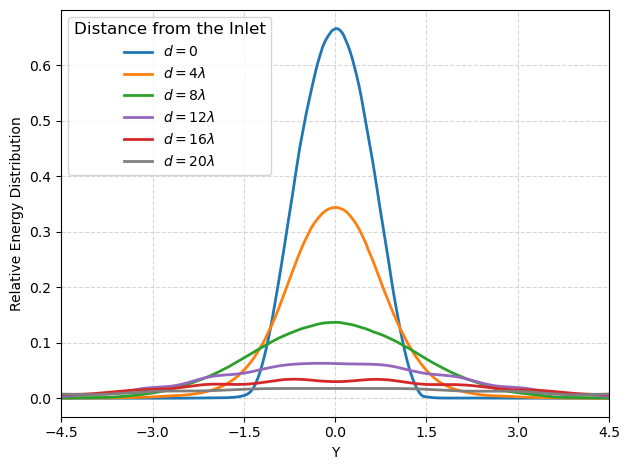

In [43]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#d62728', '#7f7f7f']

# Plot each curve with the new colors
plt.plot(y_list, mean4_norm, color=colors[0], label="$d=0$", linewidth=2)
plt.plot(y_list, mean8_norm, color=colors[1], label="$d=4\lambda$", linewidth=2)
plt.plot(y_list, mean12_norm, color=colors[2], label="$d=8\lambda$", linewidth=2)
plt.plot(y_list, mean16_norm, color=colors[3], label="$d=12\lambda$", linewidth=2)
plt.plot(y_list, mean20_norm, color=colors[4], label="$d=16\lambda$", linewidth=2)
plt.plot(y_list, mean24_norm, color=colors[5], label="$d=20\lambda$", linewidth=2)

# Add labels, legend, and show the plot
plt.xlabel("Y")
plt.ylabel("Relative Energy Distribution")
plt.legend(title="Distance from the Inlet", fontsize=10, title_fontsize=12, loc="upper left")
plt.grid(True, which="both", linestyle="--", alpha=0.5)  # Optional: Add a light grid
#plt.xlim(-7.5,7.5)
#plt.xticks([-7.5,-6,-4.5,-3,-1.5,0,1.5,3,4.5,6,7.5])

plt.xlim(-4.5,4.5)
plt.xticks([-4.5,-3,-1.5,0,1.5,3,4.5])


plt.tight_layout()
plt.savefig("EDisFlat.eps",dpi=600,bbox_inches='tight')

#plt.savefig("EnergyFlat1.png",dpi=700)

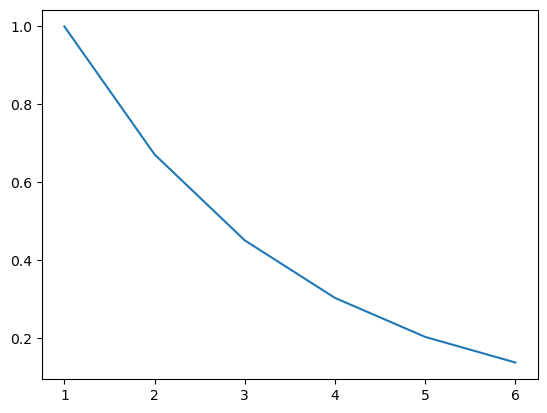

In [67]:
area4 = np.trapz(mean4_norm, y_list)
area8 = np.trapz(mean8_norm, y_list)
area12 = np.trapz(mean12_norm, y_list)
area16 = np.trapz(mean16_norm, y_list)
area20 = np.trapz(mean20_norm, y_list)
area24 = np.trapz(mean24_norm, y_list)
xxx = [1,2,3,4,5,6]
yyy = [area4,area8,area12,area16,area20,area24]
plt.plot(xxx,yyy)

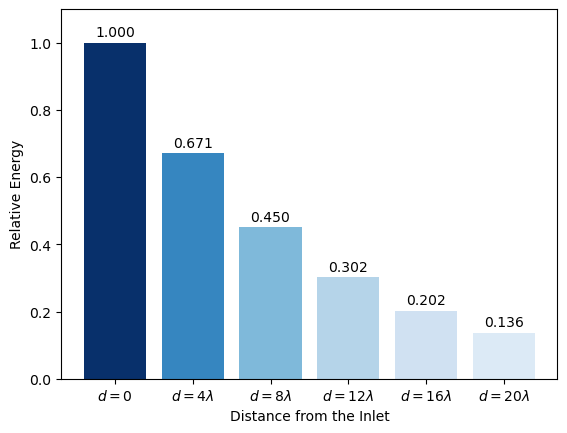

In [42]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm


# Indices for the bars (x-axis positions)
x_positions = range(len(yyy))
colors = cm.Blues(yyy)

# Plot the bar chart
plt.bar(x_positions, yyy,color=colors)

for x, y in zip(x_positions, yyy):
    plt.text(x, y + 0.01, f'{y:.3f}', ha='center', va='bottom', fontsize=10, color='black')

# Add labels and title
plt.xlabel("Distance from the Inlet")
plt.ylabel("Relative Energy")
plt.ylim(0,1.1)
#plt.title("Bar Chart Example")

# Optionally, customize the x-axis tick labels
plt.xticks(x_positions, ['$d=0$', '$d=4\lambda$', '$d=8\lambda$', '$d=12\lambda$', '$d=16\lambda$', '$d=20\lambda$'])  # Custom labels

plt.savefig("EnergyFlat.eps",dpi=600,bbox_inches='tight')
# Show the plot
plt.show()

In [51]:
y_min = -1.5
y_max = 1.5
filtered_y = [y for y in y_list if y_min <= y and y <= y_max]
filtered4 = [mean4_norm[i] for i in range(len(y_list)) if y_min <= y_list[i] and y_list[i] <= y_max]
filtered8 = [mean8_norm[i] for i in range(len(y_list)) if y_min <= y_list[i] and y_list[i] <= y_max]
filtered12 = [mean12_norm[i] for i in range(len(y_list)) if y_min <= y_list[i] and y_list[i] <= y_max]
filtered16 = [mean16_norm[i] for i in range(len(y_list)) if y_min <= y_list[i] and y_list[i] <= y_max]
filtered20 = [mean20_norm[i] for i in range(len(y_list)) if y_min <= y_list[i] and y_list[i] <= y_max]
filtered24 = [mean24_norm[i] for i in range(len(y_list)) if y_min <= y_list[i] and y_list[i] <= y_max]
Carea4 = np.trapz(filtered4, filtered_y)
Carea8 = np.trapz(filtered8, filtered_y)
Carea12 = np.trapz(filtered12, filtered_y)
Carea16 = np.trapz(filtered16, filtered_y)
Carea20 = np.trapz(filtered20, filtered_y)
Carea24 = np.trapz(filtered24, filtered_y)
print(f" {area2}")

 0.9981309101732068


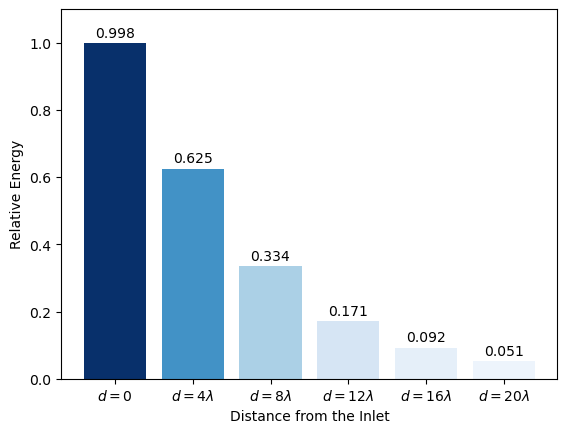

In [52]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

zzz = [Carea4,Carea8,Carea12,Carea16,Carea20,Carea24]


# Indices for the bars (x-axis positions)
x_positions = range(len(zzz))
colors = cm.Blues(zzz)

# Plot the bar chart
plt.bar(x_positions, zzz,color=colors)

for x, y in zip(x_positions, zzz):
    plt.text(x, y + 0.01, f'{y:.3f}', ha='center', va='bottom', fontsize=10, color='black')

# Add labels and title
plt.xlabel("Distance from the Inlet")
plt.ylabel("Relative Energy")
plt.ylim(0,1.1)
#plt.title("Bar Chart Example")

# Optionally, customize the x-axis tick labels
plt.xticks(x_positions, ['$d=0$', '$d=4\lambda$', '$d=8\lambda$', '$d=12\lambda$', '$d=16\lambda$', '$d=20\lambda$'])  # Custom labels

#plt.savefig("EnergyFlat.eps",dpi=600,bbox_inches='tight')
# Show the plot
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


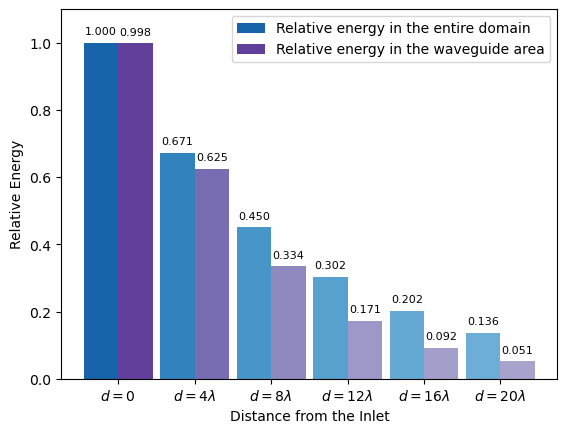

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

clim_min = 0.45
clim_max = 0.8

yyy_color_index = yyy.copy()

zzz_color_index = zzz.copy()

for i in range(len(yyy)):
    yyy_color_index[i] = clim_min + yyy[i] * (clim_max - clim_min)
    zzz_color_index[i] = clim_min + zzz[i] * (clim_max - clim_min)



# Indices for the bars (x-axis positions)
x_positions = np.arange(len(yyy))

# Get colors from the 'Blues' colormap for the first property
colors_yyy = cm.Blues(yyy_color_index)

# Get colors from the 'Oranges' colormap for the second property (it contrasts well with blue)
colors_zzz = cm.Purples(zzz_color_index)

# Set the width for each bar, ensuring they are grouped together
bar_width = 0.45

# Plot the bars for the first property (yyy) and second property (zzz)
bars_yyy = plt.bar(x_positions - bar_width/2, yyy, width=bar_width, color=colors_yyy, label="Relative energy in the entire domain")
bars_zzz = plt.bar(x_positions + bar_width/2, zzz, width=bar_width, color=colors_zzz, label="Relative energy in the waveguide area")

# Add labels and title
plt.xlabel("Distance from the Inlet")
plt.ylabel("Relative Energy")
plt.ylim(0,1.1)

# Optionally, customize the x-axis tick labels
plt.xticks(x_positions, ['$d=0$', '$d=4\lambda$', '$d=8\lambda$', '$d=12\lambda$', '$d=16\lambda$', '$d=20\lambda$'])  # Custom labels

# Add a legend to differentiate the two properties
plt.legend()

# Annotate the values on top of each bar
for bar in bars_yyy:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.3f}', ha='center', va='bottom', fontsize=8, color='black')

for bar in bars_zzz:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.3f}', ha='center', va='bottom', fontsize=8, color='black')

plt.savefig("Energy_H_Flat.eps",dpi=600,bbox_inches="tight")
# Show the plot
plt.show()